## Q-learning on CartPole (Discretized State Space)

This notebook runs **the same Q-learning algorithm** as in GridWorld.

The only difference is:
- the state space is continuous
- we discretize it by hand


The CartPole environment from Gymnasium is a classic control problem used to benchmark reinforcement learning algorithms.

**Goal:** The goal is to balance a pole, which is attached by an un-actuated joint to a cart, for as long as possible.  The cart moves along a frictionless track.  The agent must apply a force to the cart (either pushing left or right) to keep the pole upright.


<img src="https://aleksandarhaber.com/wp-content/uploads/2023/01/sketch-1-1024x608.png" width="720">



**State:** The environment provides the following four state variables at each time step:

1. **Cart Position:** The horizontal position of the cart along the track.
2. **Cart Velocity:** The velocity of the cart.
3. **Pole Angle:** The angle of the pole with respect to the vertical.  This is the crucial variable; a large angle indicates an imminent fall.
4. **Pole Angular Velocity:** The rate at which the pole's angle is changing.


| Index | Observation           | Min (Approx) | Max (Approx) |
| :---: | :-------------------- | :----------- | :----------- |
| **0** | Cart Position         | -4.8         | 4.8          |
| **1** | Cart Velocity         | -Inf         | Inf          |
| **2** | Pole Angle            | -24 deg      | +24 deg      |
| **3** | Pole Velocity at Tip  | -Inf         | Inf          |

*Note: The episode ends early if the **Cart Position** is > ±2.4 or the **Pole Angle** is > ±12 degrees.*


**Actions:**  The agent can take one of two discrete actions at each time step:

1. **Push cart to the left:** Apply a force to move the cart left.
2. **Push cart to the right:** Apply a force to move the cart right.


**Reward:** The agent receives a reward of +1 for every time step the pole remains upright.  The episode ends when:

* **Pole Angle Exceeds Threshold:** The pole tilts too far from the vertical.
* **Cart Position Exceeds Threshold:** The cart moves too far to the left or right.
* **Episode Length Limit:** A maximum number of time steps is reached (a common limit is 500).


**Difficulty:**  The challenge lies in learning a policy that balances the pole for an extended period.  Small mistakes in applying forces can quickly lead to the pole falling.


### Discretizing Continuous States

The CartPole state space is **continuous** (e.g., the pole angle could be 0.01543... degrees).
A Q-table requires **discrete** states (row 0, row 1, etc.).

To solve this, we use **Binning**:
1. We define the useful range for each variable (e.g., Angle between -12° and +12°).
2. We divide that range into $N$ buckets (bins).
3. Any continuous value falling into a bucket gets assigned that bucket's index.

**The Trade-off:** (we will observe this in experiments below)
* **Fewer Bins:** The state space is smaller ($2^4 = 16$ states). The agent learns fast, but lacks precision to balance well.
* **More Bins:** The agent has high precision, but the state space explodes ($10^4 = 10,000$ states). It takes much longer to explore and learn.

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import random

random.seed(42)
np.random.seed(42)

def discretize_state(state, bin_edges):
    """
    Discretizes a continuous state into bin indices.
    """
    state_index = []
    if isinstance(state, tuple):
        state = state[0]

    for i, value in enumerate(state):
        idx = np.digitize(value, bin_edges[i])
        state_index.append(idx)

    return tuple(state_index)



### Hyperparameters

- **bins**  
  Number of uniform bins per state dimension.  
  Controls the size of the Q-table and the trade-off between state resolution and sample efficiency (e.g., 2 vs 10 bins).

- **episodes**  
  Number of training episodes used for learning. (basically the number of times the agent plays the game to learn).

  More episodes provide more interaction data, which becomes critical as the state space grows.

- **α (alpha = 0.05 / 0.1)**  
  Learning rate for Q-value updates.  
  Smaller values lead to slower but more stable learning under noisy and sparse updates.

- **γ (gamma = 0.99)**  
  Discount factor.  
  Rewards long-term performance, which is essential for sustained pole balancing in CartPole.

- **ε (epsilon = 0.1)**  
  Exploration probability in the ε-greedy policy.  

In [ ]:
# Q-learning agent
class QLearningAgent:
    def __init__(self, env, bins, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        if isinstance(bins, int):
            self.bins = (bins, bins, bins, bins)
        else:
            self.bins = bins

        self.alpha = alpha      # Learning Rate
        self.gamma = gamma      # Discount Factor
        self.epsilon = epsilon  # Exploration Rate

        # Tight bounds. The game ends outside these, so we don't
        # waste bins on states the agent will never see.
        self.bounds = [
            [-2.4, 2.4],         # Cart Position
            [-5.0, 5.0],         # For cart velocity (Heuristic)
            [-0.209, 0.209],   # Pole Angle (~12 deg)
            [-5.0, 5.0],         # Pole Angular Velocity (Heuristic)
        ]

        # Create bins for discretization (uniformly)
        self.bin_edges = [
            np.linspace(b[0], b[1], n + 1)[1:-1]
            for b, n in zip(self.bounds, self.bins)
        ]

        # Initialize Q-table
        self.q_table = np.zeros(self.bins + (env.action_space.n,))

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""

        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()

        state_idx = discretize_state(state, self.bin_edges)
        return np.argmax(self.q_table[state_idx])

    def update_q(self, state, action, reward, next_state, done):
        """Update the Q-value based on the Q-learning update rule."""

        state_idx = discretize_state(state, self.bin_edges)
        next_state_idx = discretize_state(next_state, self.bin_edges)

        best_next_action = np.argmax(self.q_table[next_state_idx])
        target = reward + self.gamma * self.q_table[next_state_idx][best_next_action] * (not done)
        error = target - self.q_table[state_idx][action]
        self.q_table[state_idx][action] += self.alpha * error

In [ ]:
# Training and evaluation
def train_agent(agent, episodes, max_steps=200):
    rewards = []
    for episode in range(episodes):
        state, _ = agent.env.reset(seed=42)
        total_reward = 0

        for step in range(max_steps):
            action = agent.choose_action(state)

            next_state, reward, terminated, truncated, _ = agent.env.step(action)
            done = terminated or truncated

            agent.update_q(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}: Aveare Reward over last 10 iterations = {np.mean(rewards[-10:])}")
    return rewards

def evaluate_agent(agent, episodes, max_steps=200):
    rewards = []
    for _ in range(episodes):
        state, _ = agent.env.reset()
        total_reward = 0

        for step in range(max_steps):
            state_index = discretize_state(state, agent.bin_edges)
            action = np.argmax(agent.q_table[state_index])

            state, reward, terminated, truncated, _ = agent.env.step(action)
            done = terminated or truncated

            total_reward += reward

            if done:
                break

        rewards.append(total_reward)
    return np.mean(rewards)

In [ ]:
# Save GIF of the agent's performance
def save_agent_gif(agent, filename="cartpole_qlearning.gif", max_steps=200):
    frames = []
    state = agent.env.reset()
    for step in range(max_steps):
        # Capture the current frame
        frames.append(agent.env.render())
        state_index = discretize_state(state, agent.bin_edges)
        action = np.argmax(agent.q_table[state_index])
        state, _, terminated, truncated, _ = agent.env.step(action)
        done = terminated or truncated

        if done:
            break
    agent.env.close()

    # Save the frames as a GIF with looping enabled
    imageio.mimsave(filename, frames, fps=30, loop=0)
    print(f"Saved performance as {filename}")

# Plots the episodic returns during training
def plot_training_rewards(rewards, window=50):
    rewards = np.array(rewards)
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    else:
        smoothed = rewards

    plt.figure(figsize=(8, 4))
    plt.plot(smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Training Progress (Smoothed)")
    plt.grid(True)
    plt.show()

In [ ]:
# Play the GIF in Colab
def play_gif(filename):
    display(Image(filename=filename))

In [ ]:
# Function to run and log one experiment with specific bins
def run_experiment(bins, env_name="CartPole-v1", episodes=1000, max_steps=200):
    env = gym.make(env_name, render_mode="rgb_array")
    print(f"Observation space low: {env.observation_space.low}")
    print(f"Observation space high: {env.observation_space.high}")
    print(f"Running experiment with bins: {bins} per state dimension")

    agent = QLearningAgent(env, bins=bins, alpha=0.05, gamma=0.99, epsilon=0.1)

    # Train agent
    train_rewards = train_agent(agent, episodes, max_steps)

    # Plot training curve
    plot_training_rewards(train_rewards)

    # Save GIF for this bin configuration
    gif_filename = f"cartpole_bins_{bins}.gif"
    save_agent_gif(agent, filename=gif_filename)
    play_gif(gif_filename)

    # Calculate average reward
    avg_reward = evaluate_agent(agent, episodes=20, max_steps=max_steps)
    q_table_size = agent.q_table.size

    print(f"Average reward over 10 episodes: {avg_reward}")
    print(f"Q-table size: {q_table_size}")
    return bins, avg_reward, q_table_size

In [ ]:
# Final plotting after all experiments
def plot_results(results):
    bins, avg_rewards, q_table_sizes = zip(*results)

    plt.figure(figsize=(12, 6))

    # Plot performance vs. bins
    plt.subplot(1, 2, 1)
    plt.plot(bins, avg_rewards, marker="o", label="Performance")
    plt.title("Performance vs. Number of Bins")
    plt.xlabel("Number of Bins per State Dimension")
    plt.ylabel("Average Reward")
    plt.grid()
    plt.legend()

    # Plot number of bins vs. Q-table size
    plt.subplot(1, 2, 2)
    plt.plot(bins, q_table_sizes, marker="o", color="orange", label="Q-table Entries")
    plt.title("Number of Bins vs. Q-table Size")
    plt.xlabel("Number of Bins per State Dimension")
    plt.ylabel("Q-table Size")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 2 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 126.9
Episode 2000: Aveare Reward over last 10 iterations = 161.6
Episode 3000: Aveare Reward over last 10 iterations = 74.4
Episode 4000: Aveare Reward over last 10 iterations = 99.2
Episode 5000: Aveare Reward over last 10 iterations = 99.8


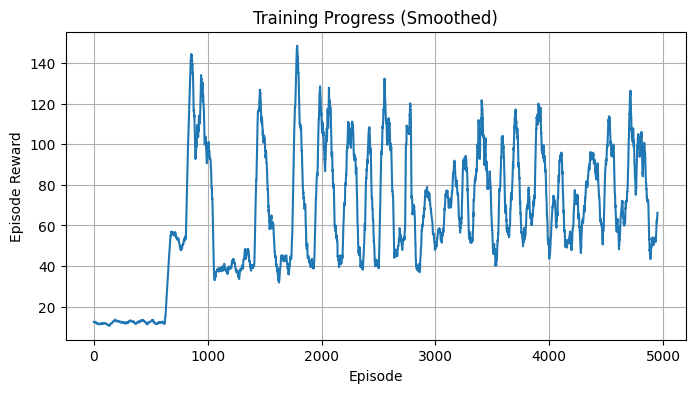

Saved performance as cartpole_bins_2.gif


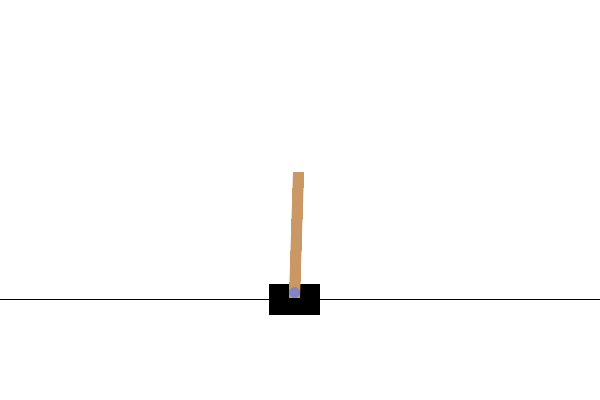

Average reward over 10 episodes: 122.85
Q-table size: 32


In [ ]:
results = []
bins = 2
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 4 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 46.5
Episode 2000: Aveare Reward over last 10 iterations = 86.5
Episode 3000: Aveare Reward over last 10 iterations = 117.2
Episode 4000: Aveare Reward over last 10 iterations = 80.3
Episode 5000: Aveare Reward over last 10 iterations = 117.6


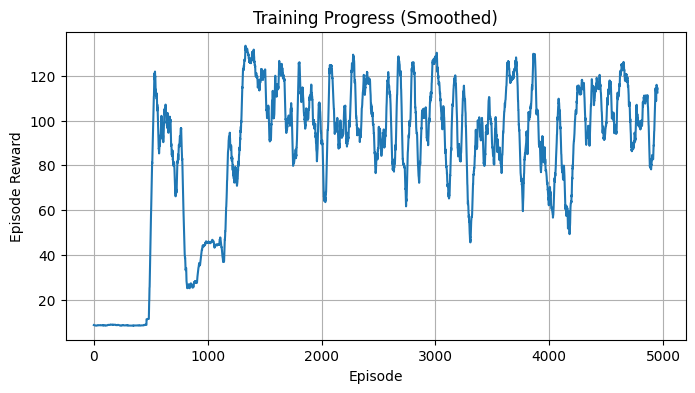

Saved performance as cartpole_bins_4.gif


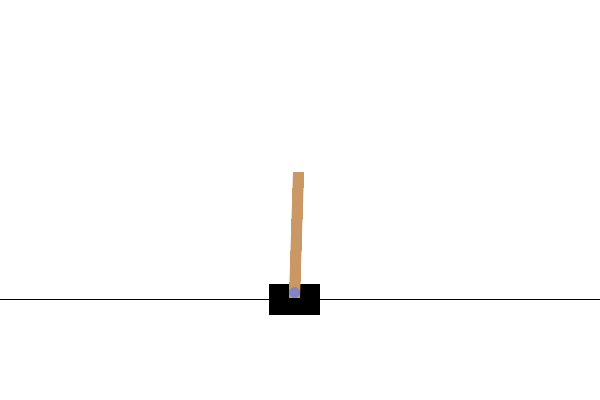

Average reward over 10 episodes: 140.55
Q-table size: 512


In [ ]:
bins = 4
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 6 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 43.3
Episode 2000: Aveare Reward over last 10 iterations = 97.3
Episode 3000: Aveare Reward over last 10 iterations = 119.6
Episode 4000: Aveare Reward over last 10 iterations = 79.9
Episode 5000: Aveare Reward over last 10 iterations = 155.0


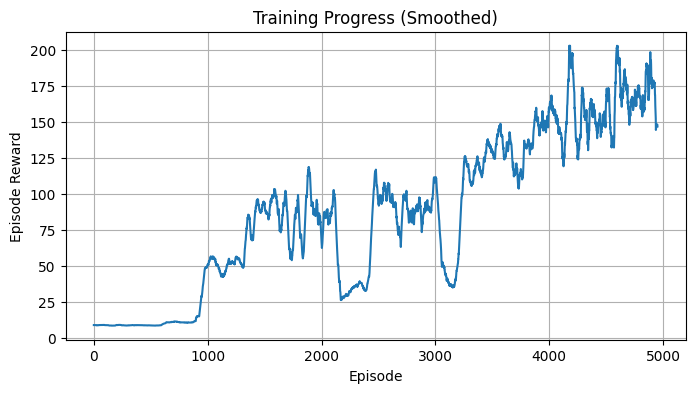

Saved performance as cartpole_bins_6.gif


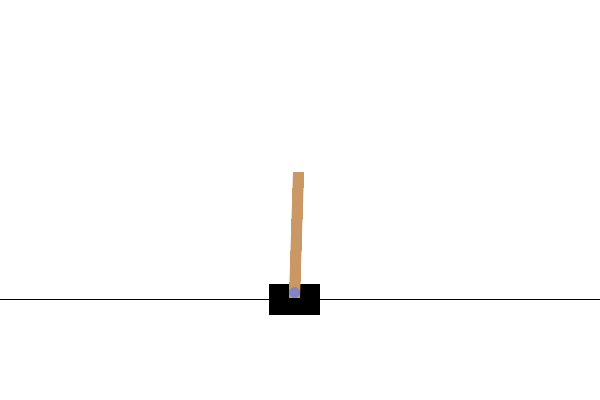

Average reward over 10 episodes: 133.55
Q-table size: 2592


In [ ]:
bins = 6
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 8 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 9.9
Episode 2000: Aveare Reward over last 10 iterations = 94.2
Episode 3000: Aveare Reward over last 10 iterations = 28.5
Episode 4000: Aveare Reward over last 10 iterations = 77.6
Episode 5000: Aveare Reward over last 10 iterations = 152.9


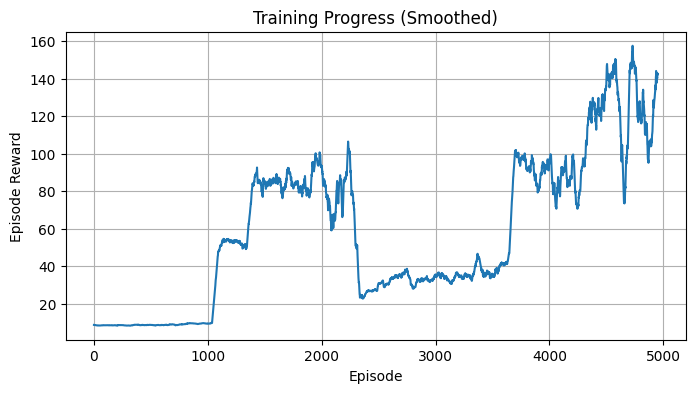

Saved performance as cartpole_bins_8.gif


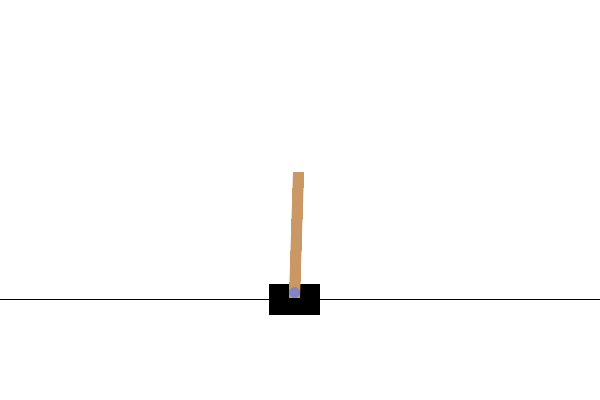

Average reward over 10 episodes: 49.35
Q-table size: 8192


In [ ]:
bins = 8
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 10 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 11.6
Episode 2000: Aveare Reward over last 10 iterations = 31.3
Episode 3000: Aveare Reward over last 10 iterations = 67.2
Episode 4000: Aveare Reward over last 10 iterations = 65.6
Episode 5000: Aveare Reward over last 10 iterations = 114.1


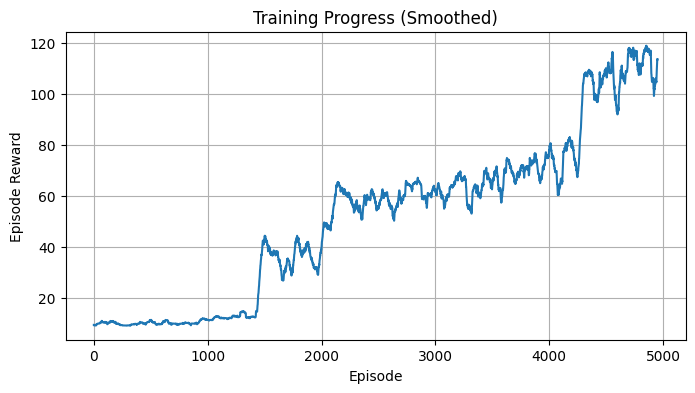

Saved performance as cartpole_bins_10.gif


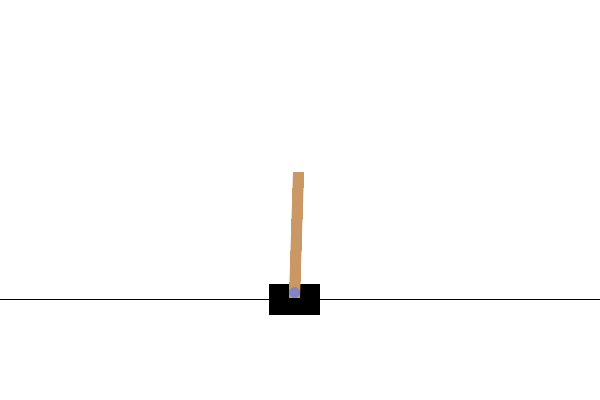

Average reward over 10 episodes: 39.9
Q-table size: 20000


In [ ]:
bins = 10
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

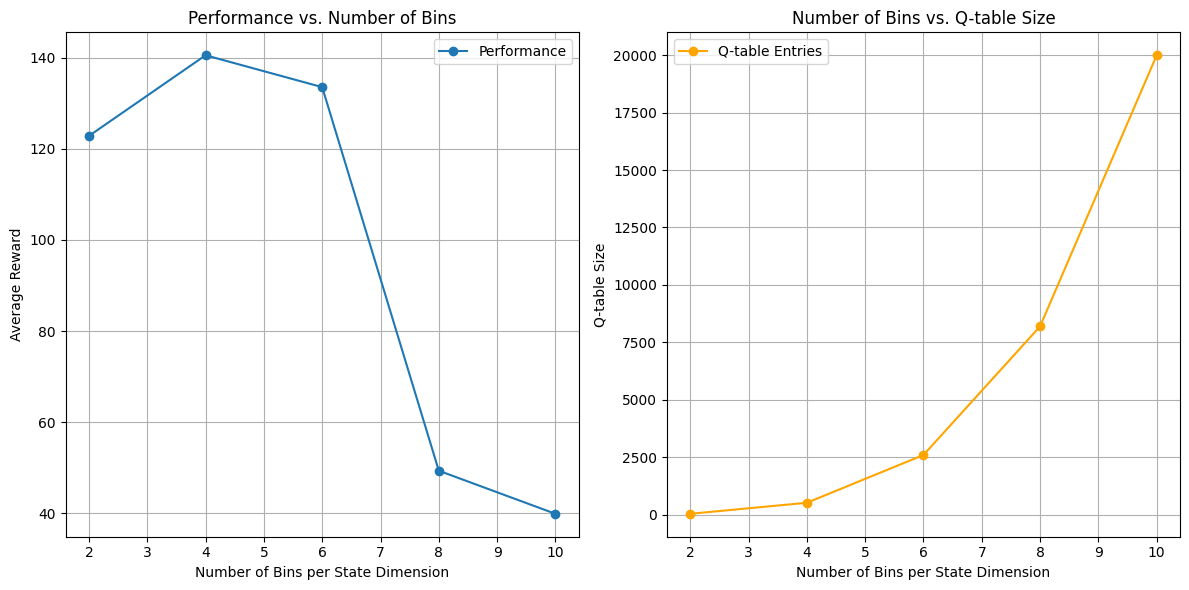

In [ ]:
# Plot results after all experiments
plot_results(results)

### Conclusion: The Curse of Dimensionality

Our experiment revealed a critical insight: **Increasing the number of bins does not automatically improve performance.**

* **Few Bins:** The agent learns quickly because the state space is small, but it **lacks precision** to balance well.
* **Many Bins:** The agent has high precision, but **insufficient data** to reliably learn values for each state–action pair.

As discretization becomes finer, the state space grows **exponentially** ($N^4$). With a fixed training budget, experience is spread too thinly, and learning becomes slow or unstable. This is the **Curse of Dimensionality**.

### The Path Forward
To scale beyond small problems, we cannot simply add more bins. We must replace tabular representations with **function approximation**, which allows the agent to generalize across similar states without visiting every single one.

This motivates our move to **Deep Q-Learning (DQN)**.

### Observations
- Sparse State Visitation
- Overfitting
- Convergence issues
- Increased memory requirements